# Toy dataset with a single invariant triplet (x, y, z)
Function: $f(x_1,x_2,x_3,x_4,x_5) = \sin \left(\log(x_1^4) \right) + \cos(5 \cdot x_2) + \sqrt{\frac{x_3^4 \cdot x_4^3}{x_5^2}}$

True invariant combination:
- $u = x_3^4 \cdot x_4^3 \cdot x_5^{-2}$  (normalized exponents $\alpha=0.743, \, \beta=0.557, \, \gamma=0.371$)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from Regression.dataset import InvarianceDataset
from Regression.model import InvarianceModel
from Regression.detector import InvarianceDetector

warnings.filterwarnings("ignore", category=DeprecationWarning)

## Creates a noisy dataset and saves it.

In [2]:
# reproducibility
np.random.seed(0)

def f_fun(x_1, x_2, x_3, x_4, x_5):
    return np.sin(np.log(x_1**4)) + np.cos(5*x_2) + np.sqrt((x_3**4 * x_4**3)/(x_5**2))

In [3]:
# sampling
N = 8000
x = np.random.uniform(1.0, 2.0, size=N)
y = np.random.uniform(0.5, 1.0, size=N)
z = np.random.uniform(2.0, 5.0, size=N)
w = np.random.uniform(3.0, 7.0, size=N)
q = np.random.uniform(1.0, 3.0, size=N)

# noiseless target
f_clean = f_fun(x, y, z, w, q)

In [4]:
# add additive Gaussian noise scaled to a fraction of the std of f
noise_frac = 0.05   # 10% of std(f)
noise = np.random.normal(0.00, noise_frac * np.std(f_clean), size=N)
f_noisy = f_clean + noise

In [5]:
# build dataframe and include the true invariant for diagnostics
df = pd.DataFrame({
    "x": x,
    "y": y,
    "z": z,
    "w": w,
    "q": q,
    "f": f_noisy
})

print(f"Dataset has N = {N}, noise_frac = {noise_frac} (i.e. {noise_frac*100:.1f}% of std(f)).")

Dataset has N = 8000, noise_frac = 0.05 (i.e. 5.0% of std(f)).


### Save dataset if first time creating it

In [6]:
dataset = InvarianceDataset(df, "f")

In [7]:
# save files for use in notebooks / examples
csv_path = "../../Data/toy_triplets_dataset.csv"
xlsx_path = "../../Data/toy_triplets_dataset.xlsx"
try:
    dataset.to_excel(xlsx_path)
except Exception:   
    # openpyxl might not be installed in some environments — ignore if save to excel fails
    xlsx_path = None
    dataset.to_csv(csv_path)

### Read dataset if already saved

In [8]:
csv_path = "../../Data/toy_triplets_dataset.csv"
xlsx_path = "../../Data/toy_triplets_dataset.xlsx"
try:
    dataset = InvarianceDataset.from_excel(xlsx_path, 'f')
except Exception:   
    # openpyxl might not be installed in some environments — ignore if save to excel fails
    xlsx_path = None
    dataset = InvarianceDataset.from_csv(csv_path, 'f')

In [9]:
# show a quick summary and the head of the dataframe
print("\nDataFrame summary (first 5 rows):\n")
print(dataset.head())

# show descriptive statistics
print("\nDescriptive statistics:\n")
print(dataset.summary())


DataFrame summary (first 5 rows):

          x         y         z         w         q          f
0  1.548814  0.728880  3.186612  3.612785  1.732364  36.834948
1  1.715189  0.688459  4.532052  3.131246  1.701277  65.175657
2  1.602763  0.851168  2.451325  3.915181  1.804735  23.888829
3  1.544883  0.603662  2.918928  4.996986  1.765485  53.766834
4  1.423655  0.537140  2.283711  4.181557  2.209320  19.668338

Descriptive statistics:

                 x            y            z            w            q  \
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000   
mean      1.495549     0.746348     3.502402     4.999200     1.998878   
std       0.289739     0.144385     0.878310     1.155851     0.573551   
min       1.000072     0.500083     2.000692     3.001380     1.000750   
25%       1.244534     0.622234     2.734352     3.988040     1.501738   
50%       1.492803     0.744100     3.512538     5.012222     1.996113   
75%       1.747077     0.872502     4.2719

## DNN model

In [10]:
X_train, X_test, y_train, y_test = dataset.train_test_split()

In [11]:
# Initialize the DNN model
model = InvarianceModel(input_dim=5)

In [12]:
# Build and compile the DNN model
model.build_and_compile(X_train)

### Train the model if not saved already

In [13]:
# Train the model
checkpoint_filepath = './tmp/checkpoint_toy_triplets.weights.h5'
model_filepath = './tmp/checkpoint_toy_triplets.keras'
model.train(X_train, y_train, checkpoint_path=checkpoint_filepath, model_path=model_filepath)

Epoch 1/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 50.6868 - val_loss: 10.6437
Epoch 2/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.2259 - val_loss: 8.7366
Epoch 3/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.1797 - val_loss: 7.8770
Epoch 4/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4975 - val_loss: 7.1954
Epoch 5/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4733 - val_loss: 5.9908
Epoch 6/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4851 - val_loss: 4.9168
Epoch 7/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7794 - val_loss: 4.3409
Epoch 8/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3905 - val_loss: 4.3510
Epoch 9/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0808 - val_loss: 4.0110
Epoch 10/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8822 - val_loss: 3.6721
Epoch 11/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7104 - val_loss: 3.5043
Epoch 12/200
181/181 ━━━━━━━━━━━━━━━━━━

In [14]:
# Save training history
history_filepath = './tmp/checkpoint_toy_triplets.pkl'
model.save_history(history_filepath)

### Otherwise, load trained model

In [15]:
# Reload model and history
history_filepath = './tmp/checkpoint_toy_triplets.pkl'
history = model.load_history(history_filepath)

model_filepath = './tmp/checkpoint_toy_triplets.keras'
model.load_model(model_filepath)

### Model metrics

In [16]:
# Evaluate on test set
r2, mae, rmse = model.evaluate(X_test, y_test)

print(f"R² = {r2:.3f}")
print(f"MAE = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R² = 0.997
MAE = 2.563
RMSE = 3.248


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


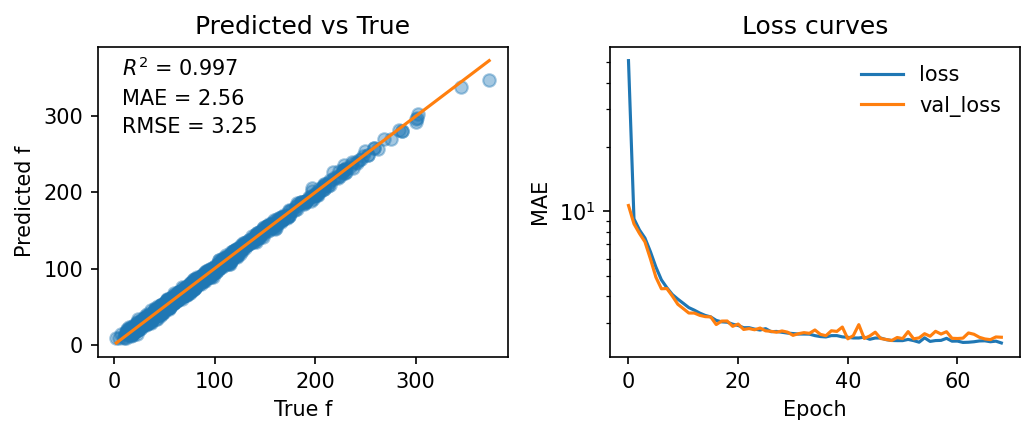

In [17]:
delta = max(y_test) - min(y_test)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), dpi=150)
test_predictions = model.predict(X_test)

# Scatter predicted vs true
ax1.scatter(y_test, test_predictions, alpha=0.4)
p1 = max(max(test_predictions), max(y_test))
p2 = min(min(test_predictions), min(y_test))
ax1.plot([p1, p2], [p1, p2], "C1")
ax1.annotate(f"$R^2$ = {r2:.3f}", xy=(0.02 * delta, 0.95 * delta))
ax1.annotate(f"MAE = {mae:.2f}", xy=(0.02 * delta, 0.85 * delta))
ax1.annotate(f"RMSE = {rmse:.2f}", xy=(0.02 * delta, 0.75 * delta))
ax1.set_xlabel("True f")
ax1.set_ylabel("Predicted f")
ax1.set_title("Predicted vs True")

# Loss curves
ax2.plot(history['loss'], label='loss')
ax2.plot(history['val_loss'], label='val_loss')
ax2.set_yscale('log')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend(frameon=False)
ax2.set_title("Loss curves")

plt.tight_layout()
plt.show()

## Invariance detection
This section performs feature grouping analysis using combinations of two features.

The analysis aims to detect invariant groups of features in the form $x_i^{\alpha_1} x_j^{\alpha_2}$.

In [18]:
# Load the pre-trained model
model = InvarianceModel(input_dim=5)
model_filepath = './tmp/checkpoint_toy_triplets.keras'
model.load_model(model_filepath)

In [19]:
# List of features
feature_names = dataset.feature_names
feature_names

['x', 'y', 'z', 'w', 'q']

In [41]:
detector = InvarianceDetector()

In [51]:
res = detector.find_invariant_triplets(dataset, model, [0.5, 0.5, -0.5], mode='product')

100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


In [52]:
print(res)

  feature_triplet    mean_a     std_a    mean_b     std_b    mean_c     std_c
0       (x, y, z) -0.024313  0.087764 -0.026010  0.061821 -0.993560  0.006810
1       (x, y, w) -0.050360  0.083802 -0.015134  0.086120 -0.991329  0.007924
2       (x, y, q)  0.001164  0.128989  0.050356  0.100704 -0.985057  0.018625
3       (x, z, w)  0.021294  0.053668  0.805274  0.034957  0.587065  0.048300
4       (x, z, q) -0.007591  0.078429  0.882122  0.027784 -0.460694  0.051398
5       (x, w, q) -0.034871  0.073350  0.816664  0.024280 -0.569460  0.039869
6       (y, z, w)  0.051322  0.083754  0.786892  0.066696  0.600679  0.076735
7       (y, z, q)  0.027510  0.057476  0.887936  0.028469 -0.451984  0.049085
8       (y, w, q)  0.031578  0.068391  0.830386  0.024414 -0.550476  0.034126
9       (z, w, q)  0.749726  0.041526  0.548242  0.048762 -0.362964  0.038678


Notice how it also found the pairs inside the triplet (i.e., $(z, w), (z, q), (w, q)$)!

In [ ]:
detector.plot_results(figsize=(6,3), dpi=200)